In [2]:
!pip install tensorflow_hub

     |████████████████████████████████| 102kB 1.8MB/s ta 0:00:011
  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

TF Version:  1.15.2
TF-Hub version:  0.8.0
Eager mode enabled:  False
GPU available:  True


In [4]:
!ls data

building.jpg  test_image.jpg


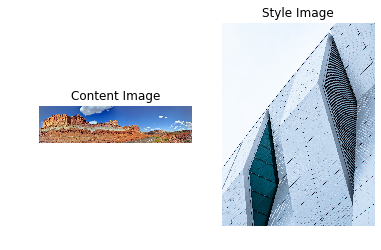

In [8]:
content_path = 'data/test_image.jpg'
style_path = 'data/building.jpg'


content_image = plt.imread(content_path)
style_image = plt.imread(style_path)
plt.subplot(1, 2, 1)
plt.title('Content Image')
plt.axis('off')
imshow(content_image)
plt.subplot(1, 2, 2)
plt.title('Style Image')
plt.axis('off')
imshow(style_image)

In [14]:

def image_to_tensor(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
    
    # Resize the image to specific dimensions
    img = tf.image.resize(img, [720, 512])
    img = img[tf.newaxis, :]
    return img

In [15]:

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    tensor = tensor[0]
    plt.figure(figsize=(20,10))
    plt.axis('off')
    return plt.imshow(tensor)

In [17]:
img = tf.io.read_file(content_path)
img = tf.image.decode_image(img, channels=3, dtype=tf.float32)

In [18]:
img

<tf.Tensor 'decode_image_4/cond_jpeg/Merge:0' shape=<unknown> dtype=float32>

In [16]:

content_image_tensor = image_to_tensor(content_path)
style_image_tensor = image_to_tensor(style_path)

ValueError: 'images' contains no shape.

In [13]:
content_image_tensor = image_to_tensor(content_path)
style_image_tensor = image_to_tensor(style_path)
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
combined_result = hub_module(tf.constant(content_image_tensor), tf.constant(style_image_tensor))[0]
tensor_to_image(combined_result)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


TypeError: List of Tensors when single Tensor expected